In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')
sys.path.append('../src/Hierarchical-Localization/')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import torch
from torch.utils.data import DataLoader


from matching.gmflow_dense.gmflow_dense import GMflowDensePose
from matching.gmflow_essential.gmflow_with_essential import GMFlowEssential
from utils.model import load_checkpoint
from utils.metrics import mAA, rotation_angle_distance_batch, vector_angle_distance_batch

from training.train_dense import test
from training.train_essential import test_ess

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

import numpy as np
from numpy.linalg import norm

import pickle
from pathlib import Path

import cv2
from scipy.spatial.transform import Rotation

from hloc import extract_features, pairs_from_retrieval
import h5py

In [5]:
device = 'cpu' #torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 0. Preparation 

### 0.1 Data

In [6]:
def read_rgb(path, mode='gray', resize=(640, 480)):
    if mode == 'rgb':
        image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    elif mode == 'gray':
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if resize:
        image = cv2.resize(image, resize)
    if len(image.shape) == 2:
        image = torch.from_numpy(image)[None].float()
    else:
        image = torch.from_numpy(image).permute(2, 0, 1).float()
    return image

In [7]:
# pairs = np.loadtxt('/home/project/code/src/Hierarchical-Localization/pairs/inloc/pairs-query-netvlad20.txt', dtype='str')
# inlock_dir = Path('/home/project/data/InLoc/')

In [8]:
# queries = set()
# pairs_filtered = []

# for pair in pairs:
#     q, s = pair[0], pair[1]
    
#     if q not in queries:
#         pairs_filtered.append((q, s))
#         queries.update([q])

### 0.2 Image retrieval

In [7]:
retrieval_conf = extract_features.confs['netvlad']

In [ ]:
outputs_db = Path('/home/project/code/results/inloc/features/db') 
outputs_queries = Path('/home/project/code/results/inloc/features/queries') 

images_db = Path('/home/project/data/InLoc/database/cutouts/') 
images_queries = Path('/home/project/data/InLoc/query/iphone7/')

loc_pairs = Path('/home/project/code/results/inloc/pairs-query-netvlad1.txt')

db_descriptors = extract_features.main(retrieval_conf, images_db, outputs_db)
q_descriptors = extract_features.main(retrieval_conf, images_queries, outputs_queries)


# pairs_from_retrieval.main(q_descriptors, loc_pairs, num_matched=1, db_descriptors=db_descriptors)

[2023/05/06 13:24:11 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
[2023/05/06 13:24:11 hloc INFO] Found 4682 images in root /home/project/data/InLoc/database/cutouts.
[2023/05/06 13:24:11 hloc.extractors.netvlad INFO] Downloading the NetVLAD model with `['wget', 'https://cvg-data.inf.ethz.ch/hloc/netvlad/Pitts30K_struct.mat', '-O', '/home/user/.cache/torch/hub/netvlad/VGG16-NetVLAD-Pitts30K.mat']`.
--2023-05-06 13:24:11--  https://cvg-data.inf.ethz.ch/hloc/netvlad/Pitts30K_struct.mat
Resolving cvg-data.inf.ethz.ch (cvg-data.inf.ethz.ch)... 129.132.114.72
Connecting to cvg-data.inf.ethz.ch (cvg-data.inf.ethz.ch)|129.132.114.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 554551295 (529M)
Saving to: ‘/home/user/.cache/torch/hub/netvlad/VGG16-NetVLAD-Pitts30K.mat’

     0K .......... .......... .......... .......... ..........  0%  593K 15m13s


In [37]:
pairs = np.loadtxt('/home/project/code/results/inloc/pairs-query-netvlad1.txt', dtype='str')

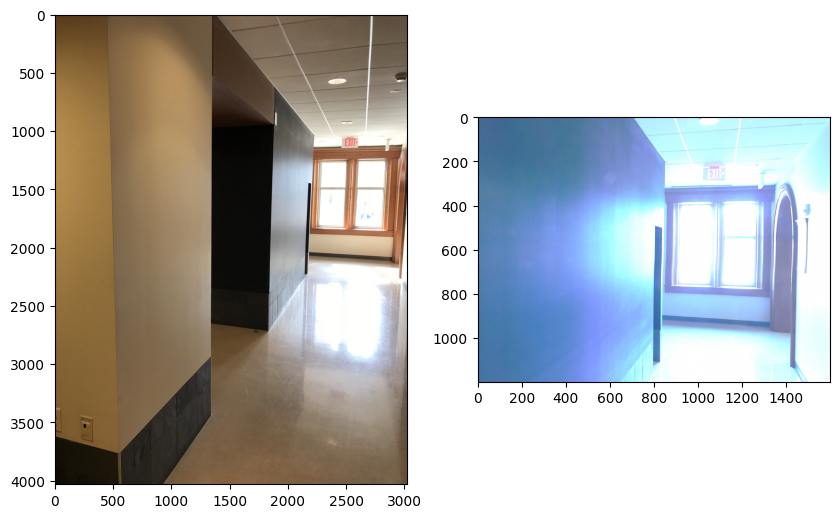

In [63]:
i = -1
query_path = inlock_dir / 'query/iphone7' / pairs[i][0]
support_path = inlock_dir / 'database/cutouts' / pairs[i][1]

fig, ax = plt.subplots(1, 2, figsize=(10, 20))

ax[0].imshow(cv2.cvtColor(cv2.imread(str(query_path)), cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(cv2.imread(str(support_path)), cv2.COLOR_BGR2RGB))

# 1.Prediction

### 1.1 GMFlow + dense

In [59]:
checkpoint = load_checkpoint('/home/project/code/src/weights/2_gmflow_dense_wo_conf_part2_3.pth', device)
model = GMflowDensePose()
model.load_state_dict(checkpoint['model'])
model.to(device);

In [60]:
model.eval()

preds = []

with torch.no_grad():
    for q, s in tqdm(pairs):
        query_path = inlock_dir / 'query/iphone7' / q
        support_path = inlock_dir / 'database/cutouts' / s

        query_image = read_rgb(str(query_path), mode='rgb', resize=(640, 480))[None, ...].to(device)
        support_image = read_rgb(str(support_path), mode='rgb', resize=(640, 480))[None, ...].to(device)
           
        quat, t = model(
                query_image, support_image,
                attn_splits_list=[2, 8],
                corr_radius_list=[-1, 4],
                prop_radius_list=[-1, 1]
               )
        
        quat = quat.cpu().numpy()
        t = t.cpu().numpy()
        #[w, x, y, z] -> [x, y, z, w]
        R = Rotation.from_quat(quat[[1, 2, 3, 0]]).as_matrix()
        T_q2s = np.zeros((4, 4))
        T_q2s[:3, :3] = R
        T_q2s[:3, 3] = t
        T_q2s[-1, -1] = 1.
        
        T_s2q = np.linalg.inv(T_q2s)
            
        floor, scan, name = str(support_path).split('/')[-3:]
        pose_path = inlock_dir / 'database/poses'/ floor / scan / (name.split('.')[0] + '.txt')

        Ts_w2c = np.loadtxt(pose_path)
        
        Ts_c2w = np.linalg.inv(Ts_w2c)
        T = T_s2q @ Ts_c2w
        
        Rq = T[:3, :3]
        tq = T[:3, 3]
        
        quat_q = Rotation.from_matrix(Rq).as_quat()[[3, 0, 1, 2]]
        preds.append((q.split('/')[-1], quat_q, tq))


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 356/356 [02:56<00:00,  2.01it/s]


In [61]:
with open('/home/project/code/results/netvlad_1_gmflow_dense.txt', 'w') as f:
    for pred in preds:
        name = pred[0]
        quat = ' '.join(map(str, pred[1]))
        t = ' '.join(map(str, pred[2]))
        f.write(f'{name} {quat} {t}\n')